**Установка и импорт библиотек**

In [ ]:
!pip install catboost
!pip install haversine
!pip install geopandas

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [44]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from datetime import datetime, timedelta

from tqdm.notebook import tqdm
from os import listdir
from haversine import haversine

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

from catboost import CatBoostRegressor

**Путь к данным**

In [ ]:
path_to_data = '/content/drive/My Drive/AIJ2020/no_flood/datasets/'

**Целевые станции**

In [ ]:
station_ids = [6005, 6022, 6027, 5004, 5012, 5024, 5805]

In [ ]:
major_stations = {6005: 'Джалинда',
                  6022: 'Благовещенск',
                  6027: 'Иннокентьевка',
                  5004: 'Ленинское',
                  5012: 'Хабаровск',
                  5024: 'Комсомольск-на-Амуре',
                  5805: 'Николаевск-на-Амуре'}

**Все, используемые станции**

Упорядоченный список станций. Будут учитываться станции до целевой.

In [ ]:
all_posts = [6003, 6005, 6010, 6016, 6020, 6022, 
             6265, 6280, 
             6363, 6373, 6286, 6296, 
             6023, 6024, 6026, 
             6456, 6473, 
             6027, 6030, 5001, 5004, 5008,
             5112, 5117, 5009, 
             5012, 5016, 5019, 5020, 5024, 5026, 5029, 5803, 5031, 
             5446, 5454, 
             5033, 5805]

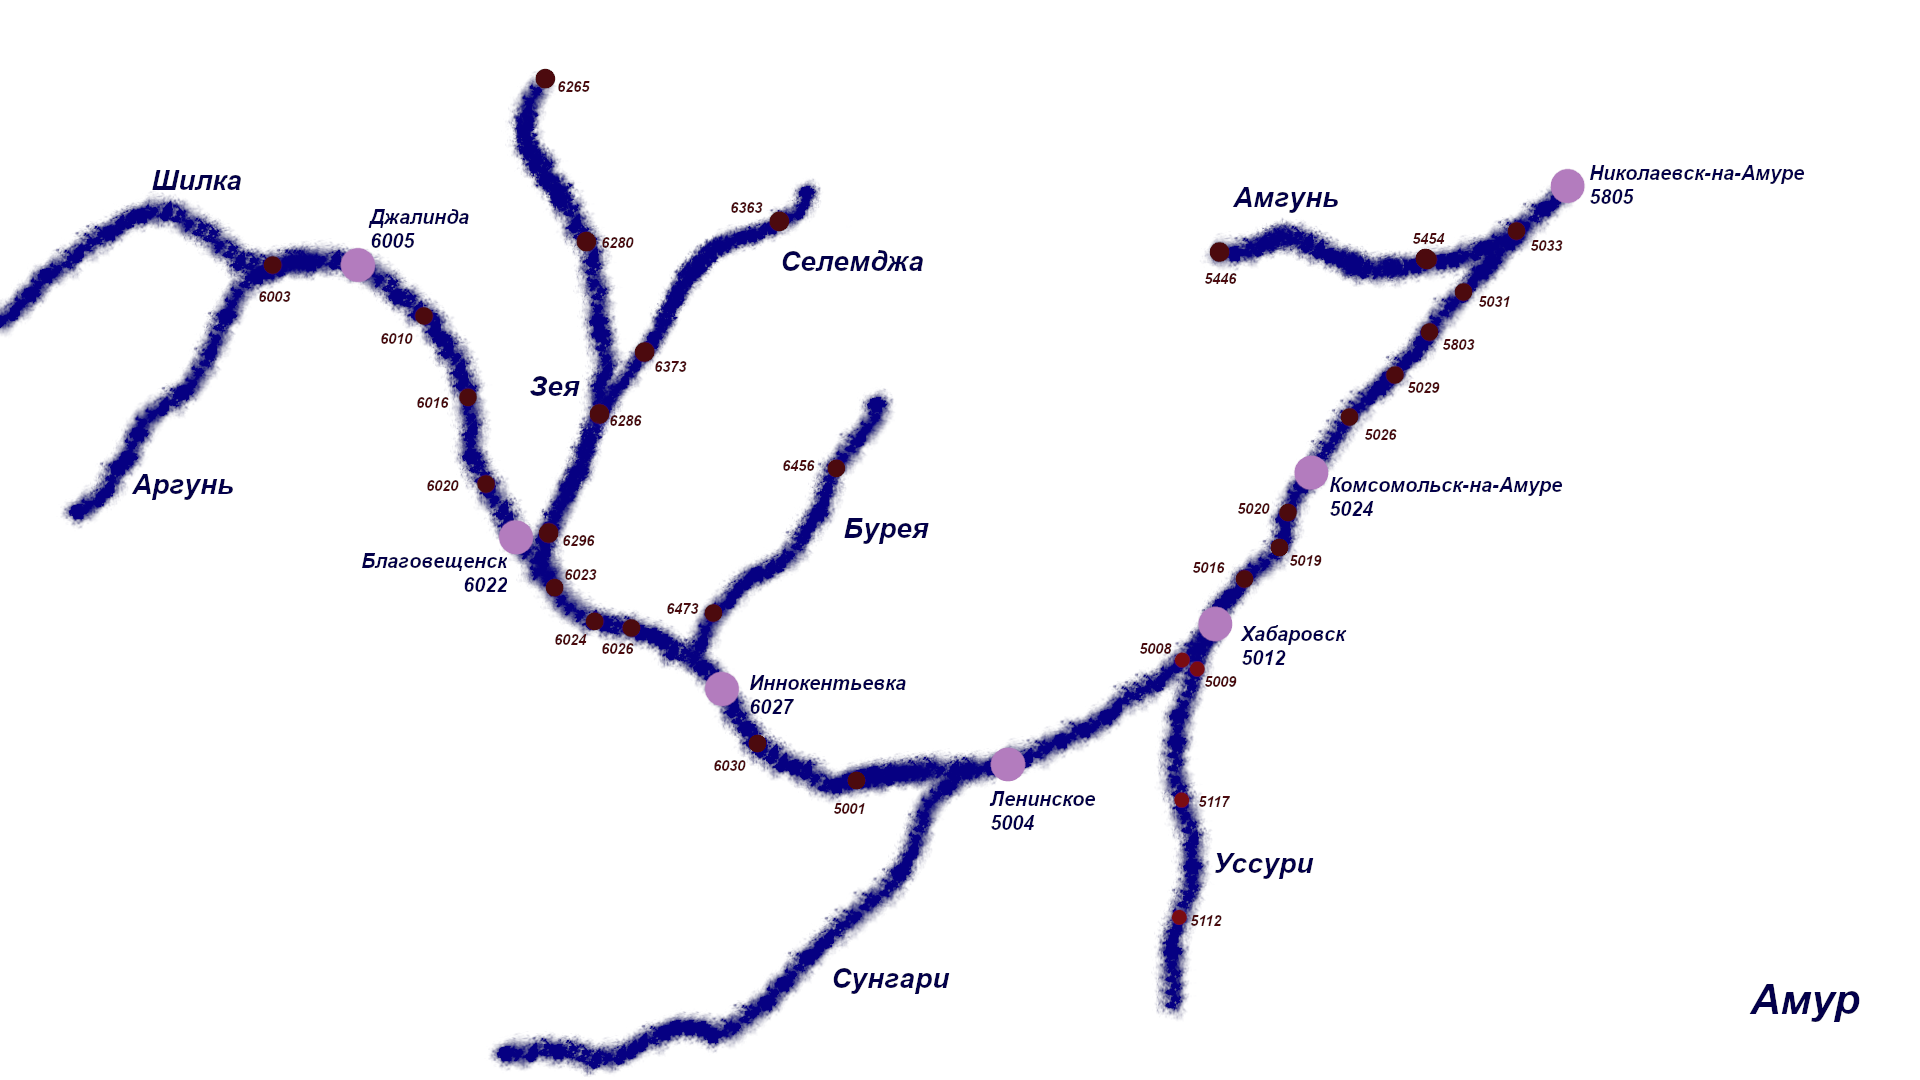

По особенностям строения речной долины выделяются три основных участка: Верхний Амур (длина 896 км) - от истока (слияния Шилки и Аргуни) до г. Благовещенска (выше устья р. Зеи) - река имеет преимущественно горный характер; Средний Амур (длина 994 км) - от г. Благовещенска (выше устья р. Зеи) до г. Хабаровска - река течет по Зейско-Бурейской равнине, затем, ниже устья р. Буреи прорезает хребет Малый Хинган, образуя единый мощный поток, и выходит на Среднеамурскую низменность. На этом участке Амур получает основное питание. Здесь в него впадают крупные притоки: слева - Зея и Бурея, справа - Сунгари и Уссури. Нижний Амур (длина 980 км) - начинается от г. Хабаровска и течет по Нижнеамурской низменности. Здесь река принимает только один значительный приток слева - р. Амгунь.

**Разделяющие станции**

In [ ]:
station_top = 6022
station_middle = 5012
station_lower = 5805

**Скорости течения**

In [ ]:
speed_top = 5 * 24  # скорость (км/сут) верхнего Амура
speed_middle = 5 * 24  # скорость (км/сут) среднего
speed_lower = 4.2 * 24  # скорость (км/сут) нижнего

**Загрузка данных с уровнями воды**

In [ ]:
def load_daily():

    daily = pd.read_pickle(path_to_data + 'processed_data/daily.pkl')
    daily = daily.drop(['stage_avg', 'stage_min'], axis=1)

    daily_new = pd.read_csv(path_to_data + 'hydro_2018-2020/new_data_all.csv', sep=';')
    daily_new['time'] = pd.to_datetime(daily_new['time'], format='%Y-%m-%d %H:%M:%S')
    daily_new.columns = ['date', 'stage_max', 'station_id']
    daily_new = daily_new[daily_new.date > '2017-12-31']
    daily_new = daily_new.reindex(['date', 'stage_max', 'temp', 'water_code', 
                                   'station_id'], axis=1)
    
    data = pd.concat([daily, daily_new], axis=0).reset_index(drop=True)

    data = data.drop(['temp', 'water_code'], axis=1)
    data = data[data.station_id.isin(all_posts)]
    return data.sort_values(by=['station_id', 'date'])

In [ ]:
data = load_daily()

In [ ]:
for post in all_posts:
    # Create figure and plot space
    fig, ax = plt.subplots(figsize=(25, 5))

    # Add x-axis and y-axis
    ax.plot(data[data.station_id == post]['date'].values,
       data[data.station_id == post]['stage_max'],
       color='#062470')
    ax.grid()
    # Set title and labels for axes
    ax.set(xlabel="Date",
       ylabel="Stage",
       title='Post - ' + str(post))

    # Define the date format
    date_form = DateFormatter("%y")
    ax.xaxis.set_major_formatter(date_form)

    # Ensure a major tick for each week using (interval=1) 
    ax.xaxis.set_major_locator(mdates.YearLocator())

    plt.show()

Output hidden; open in https://colab.research.google.com to view.

Удаление выбросов на станции 5012

In [ ]:
data.loc[(data.station_id == 5012)&(data['stage_max'] > data['stage_max'].quantile(0.99)), 'stage_max'] = np.nan

**Добавление координат гидропостов и высоты над уровнем моря**

In [ ]:
def add_coordinates_elevation(data):

    station_coords = pd.read_pickle(path_to_data + 'processed_data/station_coords.pkl')
    data = pd.merge(data, station_coords[['station_id', 'lat', 'lon']], on='station_id')

    elevations = [302, 255, 204, 168, 141, 119, 487, 196, 488, 184, 159, 125, 122,
                  112, 111, 311, 107, 86, 74, 71, 52, 43, 55, 32, 30, 28, 23, 19, 
                  14, 9, 7, 3, 0, 0, 554, 3, 0, 0]
    data['elevation'] = 0
    for i in range(len(all_posts)):
        data.loc[data.station_id == all_posts[i], 'elevation'] = elevations[i]

    return data

In [ ]:
data = add_coordinates_elevation(data) 

**Дополнение дат, чтобы дни шли без пропуска**

In [ ]:
data_start = pd.to_datetime('1984-01-01')
forecast_end = pd.to_datetime('2019-12-31')

data_days = []
data_time_of_days = []
data_day = data_start
while data_day <= forecast_end:
    data_days.append(data_day)
    data_days.append(data_day)
    data_day += timedelta(days=1)

days = pd.DataFrame()
days['date'] = data_days

In [ ]:
data_temp = pd.DataFrame()

for post in tqdm(all_posts):
    temp = pd.merge(days, data[data.station_id == post], on=['date'], how='left')
    temp.station_id = data[data.station_id == post].station_id.values[0]
    temp.lat = data[data.station_id == post].lat.values[0]
    temp.lon = data[data.station_id == post].lon.values[0]
    temp.elevation = data[data.station_id == post].elevation.values[0]

    data_temp = pd.concat([data_temp, temp], ignore_index=True) 

data_temp = data_temp.reset_index(drop=True)

In [ ]:
data = data_temp
data.head(2)

,date,stage_max,station_id,lat,lon,elevation
0,1984-01-01,NaN,6003,53.47,122.4,302
1,1984-01-01,NaN,6003,53.47,122.4,302


**Добавление календарных признаков**

In [ ]:
data = data.set_index('date')
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['day_of_year'] = data.index.dayofyear
data = data.reset_index()

**Добавление данных по толщине льда и высоте снега**

С 1 апреля по 1 ноября будет учитываться максимальная толщина льда и максимальная высота снега за зимний период. Зимой же данные будут дополнены, исходя из последних измерений.

In [ ]:
def add_ice_snow(data):

    ice = pd.read_pickle(path_to_data + 'processed_data/ice.pkl')

    wq = data[['date', 'station_id']].copy()
    wq['ice_thickness'] = 0
    wq['snow_height'] = 0

    ice = ice.sort_values(['station_id', 'date'])

    for post in tqdm(all_posts):
        last_time = '1983-12-31'
        for _, m in ice[ice.station_id == post].iterrows():
            wq.loc[(wq.station_id == post)&(wq.date > last_time)&(wq.date <= m[0]), 'ice_thickness'] = m[1]
            wq.loc[(wq.station_id == post)&(wq.date > last_time)&(wq.date <= m[0]), 'snow_height'] = m[2]
            last_time = m[0]
        for i in range(1984, 2021):
            wq.loc[(wq.station_id == post)&(wq.date >= '{}-04-01'.format(i))&
                    (wq.date < '{}-11-01'.format(i)), 'ice_thickness'] \
            = ice[(ice.station_id == post)&(ice.date >= '{}-11-01'.format(i-1))&
                    (ice.date < '{}-04-01'.format(i))]['ice_thickness'].max()
            
            wq.loc[(wq.station_id == post)&(wq.date >= '{}-04-01'.format(i))&
                    (wq.date < '{}-11-01'.format(i)), 'snow_height'] \
            = ice[(ice.station_id == post)&(ice.date >= '{}-11-01'.format(i-1))&
                    (ice.date < '{}-04-01'.format(i))]['snow_height'].max()
    
    return pd.merge(data, wq)

In [ ]:
data = add_ice_snow(data)

In [ ]:
data = data.drop_duplicates(['date', 'station_id']).reset_index(drop=True)

**Добавление метеоданных**

Будет использоваться датасет meteo_new, так как он более полный и обширный.

Функция подбора ближайших метеостанций к гидропостам

In [ ]:
def station_2_meteo():

    station_coords = pd.read_pickle(path_to_data + '/processed_data/station_coords.pkl')
    meteo_coords = pd.read_pickle(path_to_data + '/processed_data/meteo_coords.pkl')

    mypath = '/content/drive/My Drive/AIJ2020/no_flood/datasets/meteo_new/'
    onlyfiles = [f for f in listdir(mypath) if f.endswith('.csv')]

    meteo_ids_new = []
    for of in onlyfiles:
        path = mypath + of
        temp = pd.read_csv(path)
        temp = temp.rename(columns={'stationId': 'meteo_id'})
        meteo_ids_new.append(temp.meteo_id[0])

    meteo_coords = meteo_coords[['meteo_id', 'lat', 'lon']]
    s2m_new = pd.DataFrame()
    s2m_new[['station_id', 'lat', 'lon']] = station_coords[['station_id', 'lat', 'lon']]
    
    meteo_ids = []
    dists =[]
    for s, m in s2m_new[['lat', 'lon']].iterrows():
        xy = (m[0], m[1])
        min = 100000
        min_meteo_id = 0
        min_xy = (1, 2)
        for a, b in meteo_coords[['meteo_id', 'lat', 'lon']].iterrows():
            if b[0] in meteo_ids_new:
                xy2 =(b[1], b[2])
                if haversine(xy, xy2) < min:
                    min = haversine(xy, xy2)
                    min_meteo_id = b[0]
                    min_xy = xy2
        meteo_ids.append(min_meteo_id)
        dists.append(min)
    s2m_new['meteo_id'] = meteo_ids
    s2m_new['distances'] = dists
    s2m_new = s2m_new[['station_id', 'meteo_id', 'distances']]
    s2m_new = s2m_new.set_index('station_id')

    return s2m_new

Функция добавления метеоданных. Данные разделены на день и ночь. Величины облачности, Температуры воздуха, температуры почвы, относительной влажности, скорости и направления ветра, давления на уровне моря, барической тенденции и дефицита влажности взяты по средним значения, а количество осадков как суммарное за время суток. 

In [ ]:
def add_meteo(data):

    def weary_append(x, y):
        if x is not None:
            if any([a for a in list(x.columns) if a not in y.columns]) or any([a for a in list(y.columns) if a not in x.columns]):
                raise ValueError()
            else:
                return x.append(y)
        else:
            return y

    s2m_new = station_2_meteo()
    meteo_new = None
    for s, m in s2m_new.loc[all_posts][['meteo_id']].iterrows():
        m = m.values[0]
        df = pd.read_csv(path_to_data + 'meteo_new/{}.csv'.format(m)).rename({'stationId': 'meteo_id'}, axis=1)
        df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
        df['station_id'] = s
        meteo_new = weary_append(meteo_new, df)
    
    meteo_new['time_of_day'] = np.nan
    meteo_new.loc[~((meteo_new.time > 6)&(meteo_new.time <= 18)), 'time_of_day'] = 0
    meteo_new.loc[(meteo_new.time > 6)&(meteo_new.time <= 18), 'time_of_day'] = 1

    ndmeteo = meteo_new.groupby(['date', 'station_id', 'time_of_day']).agg({'cloudCoverTotal': 'mean',
                                                                        'airTemperature': 'mean',
                                                                        'soilTemperature': 'mean', 
                                                                        'relativeHumidity': 'mean', 
                                                                        'windSpeed': 'mean', 
                                                                        'windDirection': 'mean',
                                                                        'pressureReducedToMeanSeaLevel': 'mean',
                                                                        'HourPressureChange3': 'mean',
                                                                        'vapourPressure': 'mean',
                                                                        'totalAccumulatedPrecipitation': 'sum'})
    ndmeteo = ndmeteo.reset_index()
    ndmeteo.date = pd.to_datetime(ndmeteo.date)

    data = data.merge(ndmeteo, on=['station_id', 'date'])

    return data

In [ ]:
data = add_meteo(data)

**Добавление агрегированных метеоданных**

По историческим данным, наибольшее влияние оказывает изменение метеорологической обстановки за последние 2 недели.

Количество осадков суммируется за 14 и 30 дней.

Температуры воздуха и земли, относительная влажность, скорость и направление ветра, давление, барическая тенденция и дефицит влажности берется как среднее за 14 дней.

In [ ]:
def aggregate_meteo(data):
    
    roll = 28 # так как данные идут в формате день\ночь
    roll2 = 60
    for post in all_posts:

        data.loc[(data.station_id == post), 'airTemperature_14'] = data.loc[(data.station_id == post), 'airTemperature'].rolling(roll, min_periods=1).agg('mean')
        data.loc[(data.station_id == post), 'soilTemperature_14'] = data.loc[(data.station_id == post), 'soilTemperature'].rolling(roll, min_periods=1).agg('mean')
        data.loc[(data.station_id == post), 'relativeHumidity_14'] = data.loc[(data.station_id == post), 'relativeHumidity'].rolling(roll, min_periods=1).agg('mean')
        data.loc[(data.station_id == post), 'windSpeed_14'] = data.loc[(data.station_id == post), 'windSpeed'].rolling(roll, min_periods=1).agg('mean')
        data.loc[(data.station_id == post), 'windDirection_14'] = data.loc[(data.station_id == post), 'windDirection'].rolling(roll, min_periods=1).agg('mean')
        data.loc[(data.station_id == post), 'pressureReducedToMeanSeaLevel_14'] = data.loc[(data.station_id == post), 'pressureReducedToMeanSeaLevel'].rolling(roll, min_periods=1).agg('mean')
        data.loc[(data.station_id == post), 'HourPressureChange3_14'] = data.loc[(data.station_id == post), 'HourPressureChange3'].rolling(roll, min_periods=1).agg('mean')
        data.loc[(data.station_id == post), 'vapourPressure_14'] = data.loc[(data.station_id == post), 'vapourPressure'].rolling(roll, min_periods=1).agg('mean')
        data.loc[(data.station_id == post), 'totalAccumulatedPrecipitation_14'] = data.loc[(data.station_id == post), 'totalAccumulatedPrecipitation'].rolling(roll, min_periods=1).agg('sum')
        data.loc[(data.station_id == post), 'totalAccumulatedPrecipitation_30'] = data.loc[(data.station_id == post), 'totalAccumulatedPrecipitation'].rolling(roll2, min_periods=1).agg('sum')
    
    return data

In [ ]:
data = aggregate_meteo(data)

**Добавления данных об уровне воды с предыдущих станций**

In [ ]:
zeya_posts = [6265, 6280, 6286, 6296, 6023]
selemdzha_posts = [6363, 6373, 6286, 6023]
bureya_posts = [6456, 6473, 6027]
ussuri_posts = [5112, 5117, 5009, 5012]
amgun_posts = [5446, 5454, 5033]
amur_posts = [6003, 6005, 6010, 6016, 6020,
              6022, 6023, 6024, 6026, 6027,
              6030, 5001, 5004, 5008, 5012,
              5016, 5019, 5020, 5024, 5026, 
              5029, 5803, 5031, 5033, 5805]

In [ ]:
def time_to_additional_post(post, posts):
    time_btwn_posts = 0
    speed = speed_top

    for i in range(posts.index(post), len(posts)-1):

        lat1 = data[data.station_id == posts[i]]['lat'].values[0]
        lon1 = data[data.station_id == posts[i]]['lon'].values[0]
        lat2 = data[data.station_id == posts[i+1]]['lat'].values[0]
        lon2 = data[data.station_id == posts[i+1]]['lon'].values[0]

        if all_posts[i] == station_middle:
            speed = speed_middle
        if all_posts[i] == station_lower:
            speed = speed_lower

        time_btwn_posts += haversine((lat1, lon1), (lat2, lon2)) / speed

    return time_btwn_posts

In [ ]:
def time_to_amur_post(post, maj_post, posts):
    time_btwn_posts = 0
    speed = speed_top

    if maj_post not in posts:
        return 0
    
    for i in range(posts.index(post), posts.index(maj_post)):

        lat1 = data[data.station_id == posts[i]]['lat'].values[0]
        lon1 = data[data.station_id == posts[i]]['lon'].values[0]
        lat2 = data[data.station_id == posts[i+1]]['lat'].values[0]
        lon2 = data[data.station_id == posts[i+1]]['lon'].values[0]

        if all_posts[i] == station_middle:
            speed = speed_middle
        if all_posts[i] == station_lower:
            speed = speed_lower

        time_btwn_posts += haversine((lat1, lon1), (lat2, lon2)) / speed

    return time_btwn_posts

In [ ]:
def additional_posts_df(maj_st, data):

    data_maj = data[data.station_id == maj_st][['date', 'time_of_day']].copy()

    stations_for_maj = []
    for p in all_posts:
        if p == maj_st:
            break
        else:
            stations_for_maj.append(p)

    times_to_maj = []
    for post in stations_for_maj:
        if post in zeya_posts and post != zeya_posts[-1]:
            times_to_maj.append(round(time_to_additional_post(post, zeya_posts)
            + time_to_amur_post(zeya_posts[-1], maj_st, amur_posts) + 0.39))
        elif post in selemdzha_posts and post != selemdzha_posts[-1]:
            times_to_maj.append(round(time_to_additional_post(post, selemdzha_posts)
            + time_to_amur_post(selemdzha_posts[-1], maj_st, amur_posts) + 0.39))
        elif post in bureya_posts and post != bureya_posts[-1]:
            times_to_maj.append(round(time_to_additional_post(post, bureya_posts)
            + time_to_amur_post(bureya_posts[-1], maj_st, amur_posts) + 0.39))
        elif post in ussuri_posts and post != ussuri_posts[-1]:
            times_to_maj.append(round(time_to_additional_post(post, ussuri_posts)
            + time_to_amur_post(ussuri_posts[-1], maj_st, amur_posts) + 0.39))
        elif post in amgun_posts and post != amgun_posts[-1]:
            times_to_maj.append(round(time_to_additional_post(post, amgun_posts)
            + time_to_amur_post(amgun_posts[-1], maj_st, amur_posts) + 0.39))
        elif post in amur_posts:
            times_to_maj.append(round(time_to_amur_post(post, maj_st, amur_posts) + 0.39))

    for i in range(len(stations_for_maj)):
        df = data[data.station_id == stations_for_maj[i]][['date', 'stage_max', 'time_of_day']]
        df['stage_max'] = df['stage_max'].shift(times_to_maj[i] * 2)
        df = df.rename(columns={'stage_max': 'stage_max_{}_{}'.format(stations_for_maj[i], times_to_maj[i])})
        data_maj = pd.merge(data_maj, df, on=['date', 'time_of_day'], how='left')

    return data_maj

**Добавление временных признаков**

In [ ]:
def time_stage_max(df, period, year):
    for i in range(1, period+1):
        df['stage_max_{}'.format(i)] = df.stage_max.shift(i * 2)
    for i in range(year-10, year):
        df['stage_max_year_{}'.format(i)] = df[df.year == i].stage_max
    return df

**Подбор параметров модели**

Обучение до 2019 года.
Тестирование на 2019 годе.

In [48]:
def get_train_data(post, test_date):

    df = data[data.date < test_date]
    df = pd.merge(df[df.station_id == post], additional_posts_df(post, df), on=['date', 'time_of_day'], how='left')
    df = time_stage_max(df, 14, int(test_date[:4]))

    return df

In [49]:
post = 5012
test_date = '2019-01-01'

In [50]:
test = get_train_data(5012, '2020-01-01')
X_t = test.drop(['stage_max'], axis=1)
y_t = test['stage_max']
y_t = y_t.fillna(y_t.mean())

In [51]:
temp = get_train_data(5012, test_date)
temp = temp.set_index('date').drop(['station_id'], axis=1)
X = temp.drop(['stage_max'], axis=1)
y = temp['stage_max']

In [ ]:
model_temp = CatBoostRegressor(eval_metric='MAE', metric_period=200)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

In [ ]:
max = 1000
for it in [750, 1000, 1500]:
    for d in [8]:
        for r in [0.5, 0.8]:
            for od in [100]:
                model_temp = CatBoostRegressor(eval_metric='MAE', metric_period=500,
                                               iterations=it, depth=d,
                                               rsm=r, od_wait=od)
                model_temp.fit(X_train, y_train,
                               eval_set=(X_test, y_test))
                pred = model_temp.predict(X_t)
                if mean_absolute_error(y_t, pred) < max:
                    max = mean_absolute_error(y_t, model_temp.predict(X_t))
                    print(max, it, d, r, od)

Learning rate set to 0.097513
0:	learn: 126.7511997	test: 125.9929721	best: 125.9929721 (0)	total: 46.4ms	remaining: 34.8s


500:	learn: 2.9851430	test: 3.8426095	best: 3.8426095 (500)	total: 21s	remaining: 10.5s
749:	learn: 2.2751471	test: 3.2724648	best: 3.2724648 (749)	total: 31.6s	remaining: 0us

bestTest = 3.272464786
bestIteration = 749

4.790881784389257 750 8 0.5 100
Learning rate set to 0.097513
0:	learn: 126.7503338	test: 125.9891312	best: 125.9891312 (0)	total: 57.8ms	remaining: 43.3s


500:	learn: 2.9649156	test: 3.7514647	best: 3.7514647 (500)	total: 29s	remaining: 14.4s
749:	learn: 2.2520801	test: 3.1880679	best: 3.1880679 (749)	total: 43.5s	remaining: 0us

bestTest = 3.188067885
bestIteration = 749

4.559664307219782 750 8 0.8 100
Learning rate set to 0.081513
0:	learn: 128.8905090	test: 128.1406739	best: 128.1406739 (0)	total: 42.1ms	remaining: 42.1s


500:	learn: 3.2930223	test: 4.0308041	best: 4.0308041 (500)	total: 21.2s	remaining: 21.1s
999:	learn: 2.0483892	test: 3.0270334	best: 3.0270334 (999)	total: 42.2s	remaining: 0us

bestTest = 3.027033427
bestIteration = 999

4.480332134405799 1000 8 0.5 100
Learning rate set to 0.081513
0:	learn: 128.8887695	test: 128.1360988	best: 128.1360988 (0)	total: 56.9ms	remaining: 56.8s


500:	learn: 3.1930261	test: 4.0256064	best: 4.0256064 (500)	total: 28.9s	remaining: 28.8s
999:	learn: 1.9759084	test: 3.0342024	best: 3.0342024 (999)	total: 57.8s	remaining: 0us

bestTest = 3.034202447
bestIteration = 999

4.369796754603994 1000 8 0.8 100
Learning rate set to 0.063317
0:	learn: 131.3282236	test: 130.5869731	best: 130.5869731 (0)	total: 61ms	remaining: 1m 31s


500:	learn: 3.5913567	test: 4.2670194	best: 4.2670194 (500)	total: 21s	remaining: 41.9s
1000:	learn: 2.3254465	test: 3.2175911	best: 3.2175911 (1000)	total: 42.3s	remaining: 21.1s
1499:	learn: 1.7087109	test: 2.7385079	best: 2.7385079 (1499)	total: 1m 3s	remaining: 0us

bestTest = 2.73850788
bestIteration = 1499

4.10473482657559 1500 8 0.5 100
Learning rate set to 0.063317
0:	learn: 131.3252161	test: 130.5820001	best: 130.5820001 (0)	total: 56.5ms	remaining: 1m 24s


500:	learn: 3.5400156	test: 4.2491511	best: 4.2491511 (500)	total: 29s	remaining: 57.9s
1000:	learn: 2.2846173	test: 3.1884776	best: 3.1884776 (1000)	total: 58.1s	remaining: 28.9s
1499:	learn: 1.6479722	test: 2.6970253	best: 2.6970253 (1499)	total: 1m 27s	remaining: 0us

bestTest = 2.69702526
bestIteration = 1499



**Создание моделей для каждого гидропоста**

In [52]:
models = []

In [53]:
def model_for_station(post, X, y):
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                        random_state=17)
    model = CatBoostRegressor(iterations=1500, depth=8,
                              rsm=0.5, od_wait=100,
                              eval_metric='MAE')
    
    model.fit(X_train, y_train, eval_set=(X_val, y_val), silent=True)
    print('Model for {} post.'.format(post), 'MAE = {}'.format(mean_absolute_error(y, model.predict(X))))
    return model

In [54]:
for post in all_posts:

    print(str(all_posts.index(post)+1) + '/' + str(len(all_posts)), end=' ')
    temp = get_train_data(post, test_date)
    temp = temp.set_index('date').drop(['station_id'], axis=1)
    X = temp.drop(['stage_max'], axis=1)
    y = temp['stage_max']
    y = y.fillna(y.mean())

    models.append(model_for_station(post, X, y))

In [ ]:
for i in range(len(models)):
    models[i].save_model('/content/drive/My Drive/AIJ2020/no_flood/models/model_{}'.format(all_posts[i]))

**Функции для получения предсказаний**

In [ ]:
def get_test_data(test, post, forecast_day):

    df = test
    df.loc[(df.date >= forecast_day), 'stage_max'] = np.nan
    df = pd.merge(df[df.station_id == post], additional_posts_df(post, df), on=['date', 'time_of_day'], how='left')
    df = time_stage_max(df, 14, int(forecast_day.year))

    return df

In [ ]:
def get_preds(forecast_start, forecast_end):

    models = []
    for post in all_posts:
        model = CatBoostRegressor()
        model.load_model('/content/drive/My Drive/AIJ2020/no_flood/models/model_{}'.format(post))
        models.append(model)
    
    test = data.copy()
    predicts = []
    true_predicts = []
    forecast_start = pd.to_datetime(forecast_start)
    forecast_end = pd.to_datetime(forecast_end)

    forecast_days = []
    forecast_day = forecast_start
    pred_num = 0
    while forecast_day <= forecast_end:
    
        predicts.append([])
        true_predicts.append([])
        print(str(pred_num + 1) + '/' + str((forecast_end - forecast_start).days))
        m = 0
        for post in all_posts:

            forc = get_test_data(test, post, forecast_day)
            forc = forc[forc.date == forecast_day].drop(['stage_max', 'station_id'], axis=1).set_index('date')

            model = models[m]
            m += 1
            pred = model.predict(forc).mean()
            true_pred = data[(data.station_id == post)&(data.date == forecast_day)].stage_max.values.max()

            test.loc[(test.station_id == post)&(test.date == forecast_day), 'stage_max'] = pred
            if post in major_stations:
                print('Post:', post, '| predict:', pred, '| true:', true_pred)
        
            true_predicts[pred_num].append(true_pred.mean())
            predicts[pred_num].append(pred)

        forecast_day += timedelta(days=1)
        pred_num += 1

    return pd.DataFrame(predicts, columns=all_posts), pd.DataFrame(true_predicts, columns=all_posts)

**Прогноз половодья на 10 дней**

In [45]:
pred_df, true_df = get_preds('2019-04-10', '2019-04-20')

1/10
Post: 6005 | predict: 71.27806430488225 | true: 73.0
Post: 6022 | predict: -26.28571549565214 | true: -28.0
Post: 6027 | predict: 109.01025874792602 | true: 86.0
Post: 5004 | predict: 245.6042628028809 | true: 233.0
Post: 5012 | predict: -42.09325721789253 | true: -46.0
Post: 5024 | predict: -82.91236251442803 | true: -77.0
Post: 5805 | predict: 61.63978357833831 | true: 66.0
2/10
Post: 6005 | predict: 57.19552738055241 | true: 74.0
Post: 6022 | predict: 27.586648307291163 | true: -22.0
Post: 6027 | predict: 93.17396778940929 | true: 81.0
Post: 5004 | predict: 193.84867039093 | true: 234.0
Post: 5012 | predict: -96.57953758722753 | true: -44.0
Post: 5024 | predict: -124.55023837244545 | true: -71.0
Post: 5805 | predict: 58.954813604730774 | true: 68.0
3/10
Post: 6005 | predict: 47.00977969315643 | true: 75.0
Post: 6022 | predict: 24.99025765218928 | true: -15.0
Post: 6027 | predict: 100.52848957519181 | true: 82.0
Post: 5004 | predict: 155.15829846678392 | true: 238.0
Post: 5012 |

MAE: 12.740792494658054


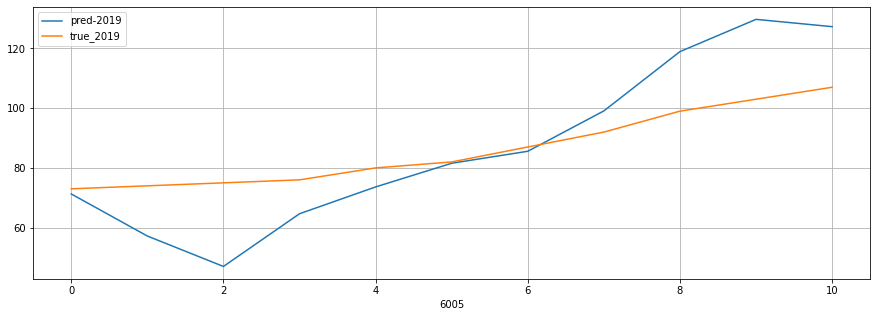

MAE: 24.0580310974388


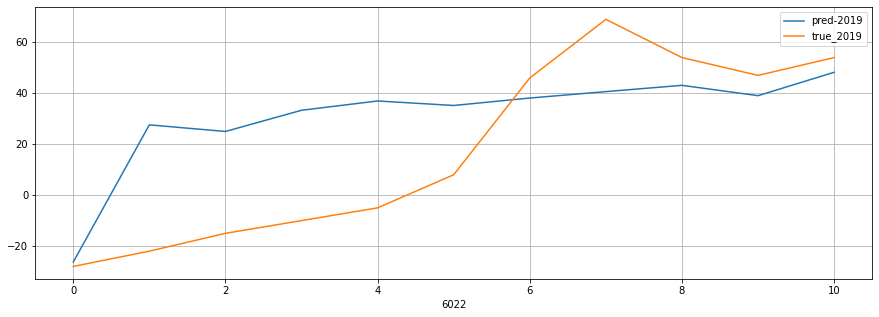

MAE: 77.31500380887631


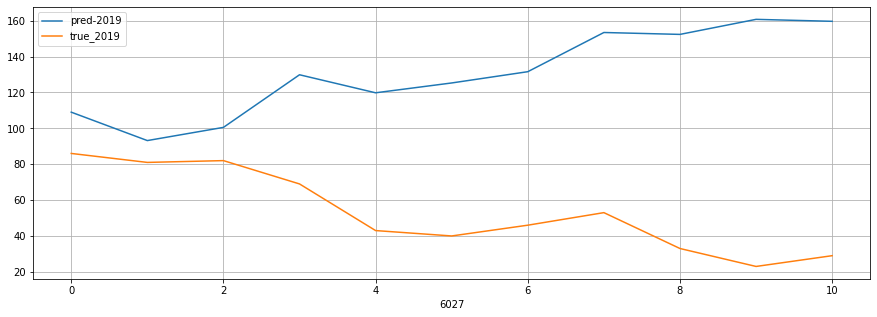

MAE: 69.40045360596528


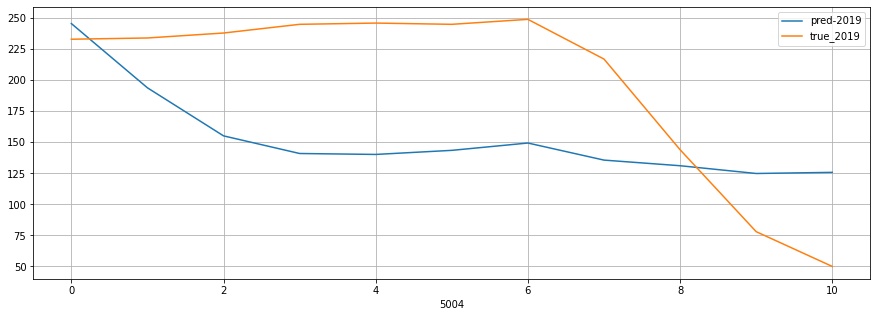

MAE: 100.47522616456932


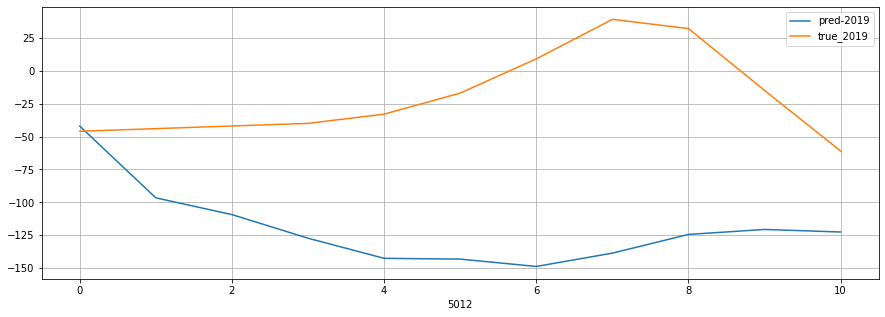

MAE: 130.47114352420942


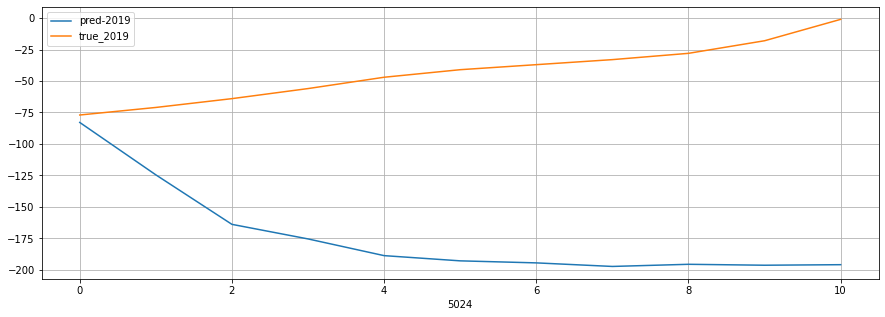

MAE: 18.304353356710138


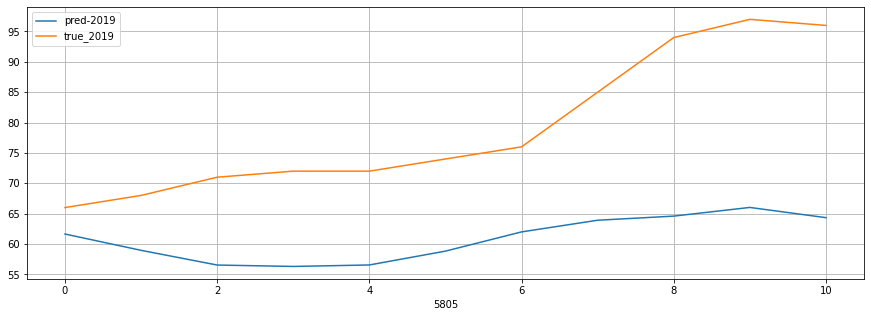

Mean MAE: 61.823572007489624


In [57]:
mean_mae = 0
for post in major_stations:
    print('MAE:', mean_absolute_error(true_df[post], pred_df[post]))
    mean_mae += mean_absolute_error(true_df[post], pred_df[post])
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(pred_df[post].reset_index(drop=True))
    ax.plot(true_df[post].reset_index(drop=True))
    ax.grid()
    ax.set(xlabel=str(post))
    ax.legend(['pred-2019', 'true_2019'])
    plt.show()

print('Mean MAE:', mean_mae / 7)

**Прогноз в период паводка на 10 дней вперед**

In [59]:
pred_df, true_df = get_preds('2019-08-10', '2019-08-20')

1/10
Post: 6005 | predict: 202.30679868560767 | true: 198.0
Post: 6022 | predict: 321.6936013969545 | true: 346.0
Post: 6027 | predict: 820.6068549536046 | true: 753.0
Post: 5004 | predict: 864.5860443710501 | true: 905.0
Post: 5012 | predict: 545.2583083386351 | true: 531.0
Post: 5024 | predict: 349.1577077799611 | true: 359.0
Post: 5805 | predict: 131.91224337469302 | true: 139.0
2/10
Post: 6005 | predict: 138.91584053995786 | true: 192.0
Post: 6022 | predict: 61.259945274816715 | true: 328.0
Post: 6027 | predict: 249.60270684368385 | true: 681.0
Post: 5004 | predict: 238.54605108076848 | true: 907.0
Post: 5012 | predict: 16.23762548896744 | true: 543.0
Post: 5024 | predict: -3.09600585093634 | true: 372.0
Post: 5805 | predict: 114.02420633473919 | true: 141.0
3/10
Post: 6005 | predict: 133.8613772709101 | true: 189.0
Post: 6022 | predict: 42.63618103555836 | true: 306.0
Post: 6027 | predict: 188.81743870403017 | true: 631.0
Post: 5004 | predict: 222.42058058646813 | true: 902.0
Post

MAE: 31.73766833221081


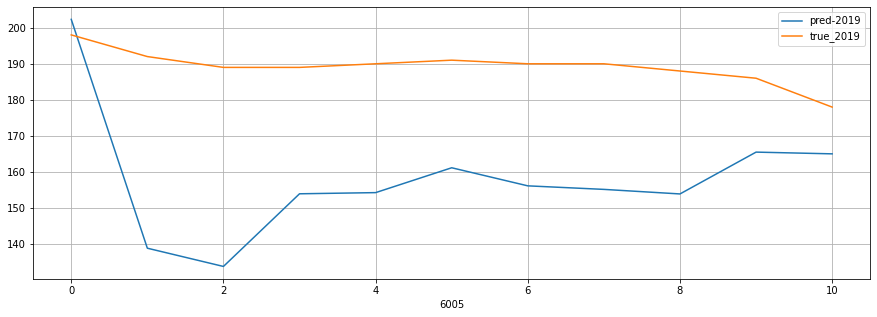

MAE: 182.5878256310447


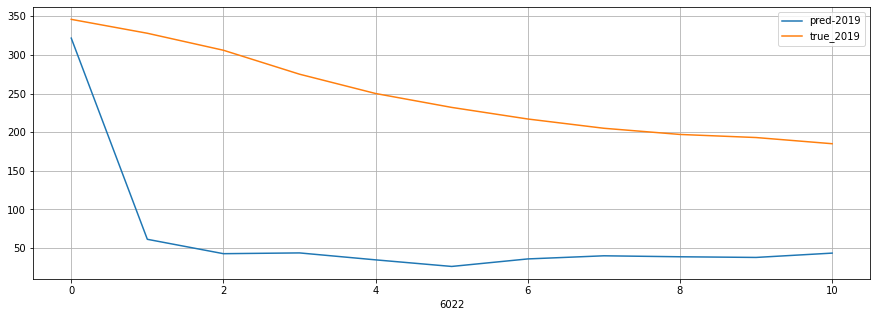

MAE: 343.3358710403372


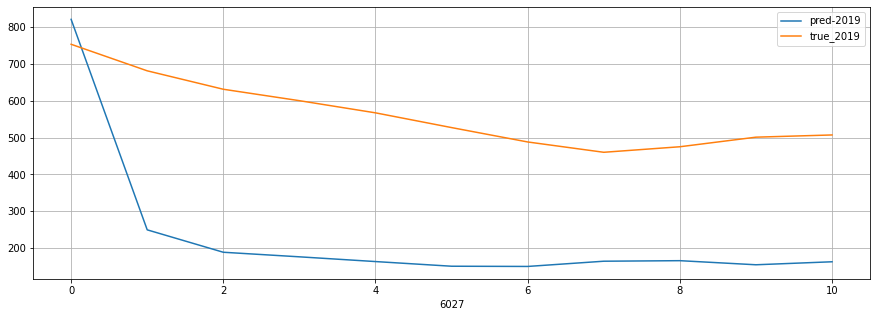

MAE: 630.8448795017431


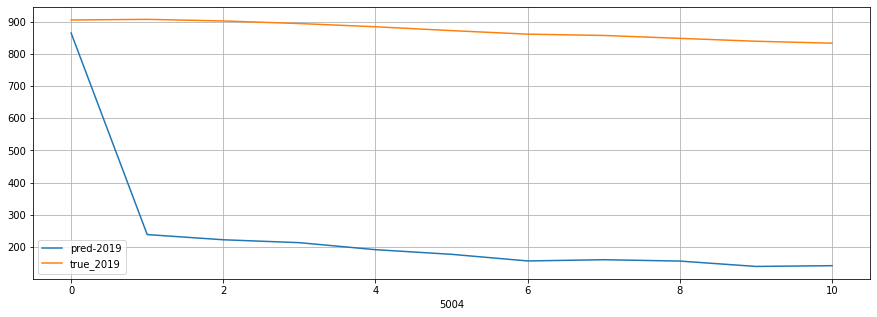

MAE: 593.0258075023249


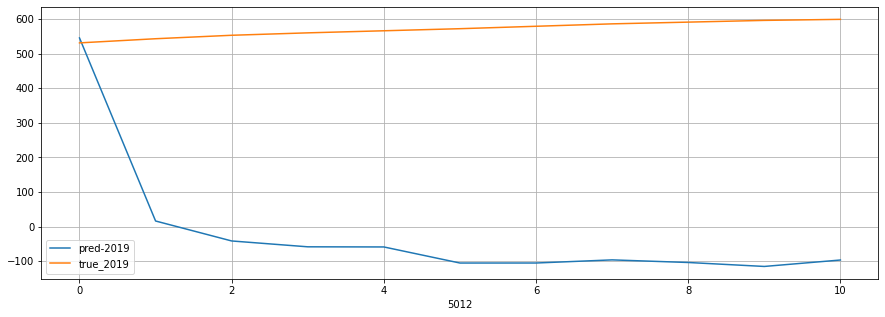

MAE: 503.1202740526684


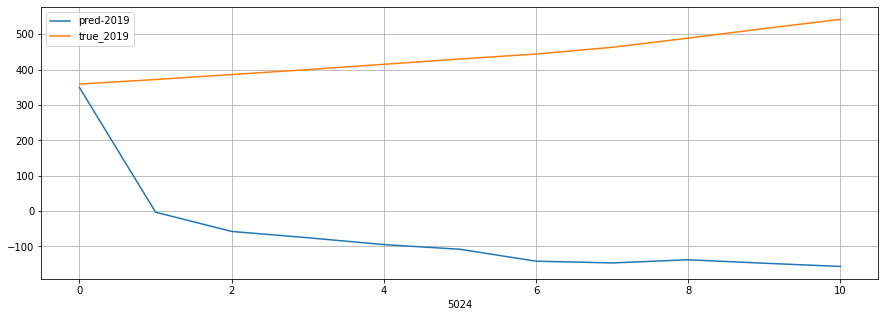

MAE: 54.07916921732737


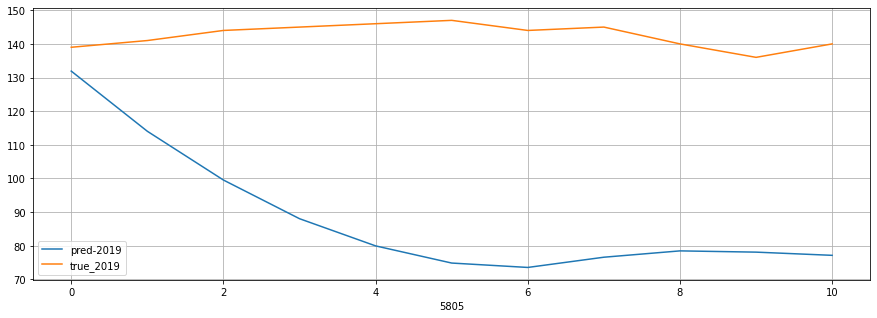

Mean MAE: 334.1044993253795


In [60]:
mean_mae = 0
for post in major_stations:
    print('MAE:', mean_absolute_error(true_df[post], pred_df[post]))
    mean_mae += mean_absolute_error(true_df[post], pred_df[post])
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(pred_df[post].reset_index(drop=True))
    ax.plot(true_df[post].reset_index(drop=True))
    ax.grid()
    ax.set(xlabel=str(post))
    ax.legend(['pred-2019', 'true_2019'])
    plt.show()

print('Mean MAE:', mean_mae / 7)

**Прогноз на долгосрочный период (1 месяц)**

In [ ]:
pred_df, true_df = get_preds('2019-07-01', '2019-07-31')

1/30
Post: 6005 | predict: 100.02439114067916 | true: 93.0
Post: 6022 | predict: 155.05463504227492 | true: 205.0
Post: 6027 | predict: 386.12178355773324 | true: 464.0
Post: 5004 | predict: 406.38961715949983 | true: 435.0
Post: 5012 | predict: 159.70577532096627 | true: 179.0
Post: 5024 | predict: 182.67514245945688 | true: 190.0
Post: 5805 | predict: 141.688380384736 | true: 148.0
2/30
Post: 6005 | predict: 85.24205746131821 | true: 94.0
Post: 6022 | predict: 14.451036783656718 | true: 186.0
Post: 6027 | predict: 186.76323389119398 | true: 486.0
Post: 5004 | predict: 190.862261809325 | true: 454.0
Post: 5012 | predict: -15.169488702865042 | true: 194.0
Post: 5024 | predict: -17.933537517305343 | true: 185.0
Post: 5805 | predict: 118.5469908688572 | true: 140.0
3/30
Post: 6005 | predict: 85.05262247510257 | true: 99.0
Post: 6022 | predict: -2.149214296728019 | true: 156.0
Post: 6027 | predict: 120.66925691944388 | true: 504.0
Post: 5004 | predict: 172.55942865179293 | true: 492.0
Pos

In [ ]:
mean_mae = 0
for post in major_stations:
    print('MAE:', mean_absolute_error(true_df[post], pred_df[post]))
    mean_mae += mean_absolute_error(true_df[post], pred_df[post])
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(pred_df[post].reset_index(drop=True))
    ax.plot(true_df[post].reset_index(drop=True))
    ax.grid()
    ax.set(xlabel=str(post))
    ax.legend(['pred-2019', 'true_2019'])
    plt.show()

print('Mean MAE:', mean_mae / 7)